In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


(1, 360, 360, 3)
(1, 260, 260, 3)
(1, 160, 160, 3)


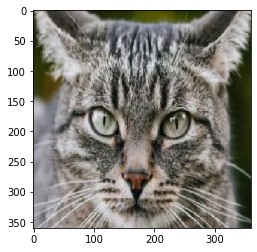

In [5]:
PATH = '/content/gdrive/My Drive/data/template-matching/'

# show results
import matplotlib
import matplotlib.pyplot as plt

# create a template
side = 360
scale_level = 3
list_of_templates = []

for i in range(scale_level):
  template = kimage.load_img(PATH+'template_cat1.jpg', target_size=(side-100*i, side-100*i))
  template = np.expand_dims(template, axis=0)
  list_of_templates.append(template)

# check
for i in range(scale_level):
  print(list_of_templates[i].shape)

# show a template
plt.figure(figsize=(4,4))
plt.imshow(list_of_templates[0][0])

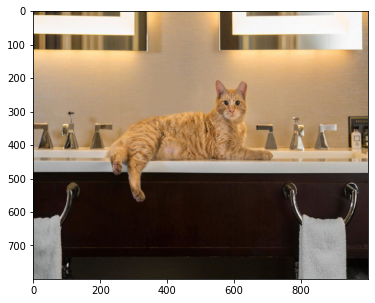

In [6]:
height = 800
width  = 1000

# load an image
image_path = PATH+'image8.jpg'
image = kimage.load_img(image_path, target_size=(height, width))
image = np.expand_dims(image, axis=0)

plt.figure(figsize=(6,6))
plt.imshow(image[0])

In [7]:
model = tf.keras.applications.VGG16(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(None, None, 3))
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [10]:
# compute features for templates
list_of_features = []
for i in range(scale_level):
  features = model.predict(list_of_templates[i])
  list_of_features.append(features)

# compute features for image
image_features = model.predict(image)

# check
print(image_features.shape)
for i in range(scale_level):
  print(list_of_features[i].shape)

(1, 25, 31, 512)
(1, 11, 11, 512)
(1, 8, 8, 512)
(1, 5, 5, 512)


In [11]:
for i in range(scale_level):
  side_fm = list_of_features[i].shape[1]
  height_fm = image_features.shape[1]
  width_fm  = image_features.shape[2]
  print(side_fm, height_fm, width_fm)

11 25 31
8 25 31
5 25 31


In [23]:
sim_data = []
height_fm = image_features.shape[1]
width_fm  = image_features.shape[2]

for s in range(scale_level):
  side_fm = list_of_features[s].shape[1]
  
  for i in range(height_fm-side_fm+1):
    for j in range(width_fm-side_fm+1):
      patch = image_features[0,i:i+side_fm,j:j+side_fm,:]
      sim = cosine_similarity(np.reshape(patch, (1, -1)), np.reshape(list_of_features[s], (1,-1)))
      sim_data.append((sim[0][0], i, j, side-100*s))

print(len(sim_data))

1314


In [24]:
def getKey(item):
    return item[0]

sim_data_sorted = sorted(sim_data, key=getKey, reverse=True)
print(sim_data_sorted[:3])

[(0.45826495, 6, 16, 160), (0.3812665, 6, 17, 160), (0.37532684, 7, 16, 160)]


<Figure size 1152x1152 with 0 Axes>

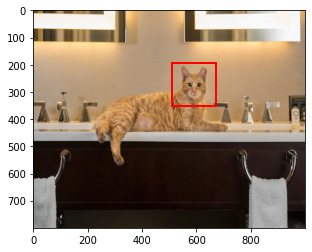

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(image_path, target_size=(800, 1000))

plt.figure(figsize=(16,16))
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
scale_height = height//height_fm
scale_width  = width//width_fm
for i in range(1): 
  rect = patches.Rectangle((sim_data_sorted[i][2]*scale_width, sim_data_sorted[i][1]*scale_height), 
                          sim_data_sorted[i][3], sim_data_sorted[i][3], 
                          linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
plt.show()